In [ ]:
#### Since the model will not be able to really learn whether or not an animal is dangerous to a chicken by looking at a picture of it
#### We have to make a model that can detect what animal it is, then based on that using the animal descriptors, we can decide on if it will be dangerous
#### We can compare and contrast this to the model that just uses the dangerous/not dangerous label and see which one is best.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Ds9000/datasets/

/content/drive/My Drive/Ds9000/datasets


In [ ]:
ls

animals.csv    DB_Retinopathy/                   winequality_missing.csv
animals_data/  Final_Project_Test_Set/           winequality_test.csv
cat_or_dog/    Head_Neck_Cancer_Clinics_HPV.csv  winequality_train.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# load in the csv file containing descriptors of animals
animal_descriptor = pd.read_csv('animals.csv')

##### An animal is dangerous to a chicken if is not aquatic and bigger than a chicken and not a herbivore #####
animal_descriptor["dangerous"] = (
    (animal_descriptor[" aqautic"] != 1) &
    (animal_descriptor[" biggerThanChicken"] == 1) &
    (animal_descriptor[" diet"] != " Herbivore")
).astype(int)

In [ ]:
%load_ext google.colab.data_table
animal_descriptor

,Animal,diet,biggerThanChicken,aqautic,dangerous
0,Antelope,Herbivore,1,0,0
1,Badger,Omnivore,1,0,1
2,Bat,Omnivore,0,0,0
3,Bear,Omnivore,1,0,1
4,Bee,Herbivore,0,0,0
...,...,...,...,...,...
85,Whale,Carnivore,1,1,0
86,Wolf,Carnivore,1,0,1
87,Wombat,Herbivore,1,0,0
88,Woodpecker,Omnivore,0,0,0


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset_into_train_validation_test(source_dir, train_size, validation_size, test_size):
    # Create directories
    train_dir = os.path.join(source_dir, 'train')
    validation_dir = os.path.join(source_dir, 'validation')
    test_dir = os.path.join(source_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all subdirectories (animal classes)
    subdirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(source_dir, subdir)
        files = [f for f in os.listdir(subdir_fullpath) if os.path.isfile(os.path.join(subdir_fullpath, f))]

        # Check if there are files in the directory
        if not files:
            continue

        # Split files according to the given ratios
        train_files, test_files = train_test_split(files, test_size=(validation_size + test_size), random_state=42)
        validation_files, test_files = train_test_split(test_files, test_size=test_size/(validation_size + test_size), random_state=42)

        # Function to copy the files to the respective directories
        def copy_files(files, dest):
            dest_path = os.path.join(source_dir, dest, subdir)
            os.makedirs(dest_path, exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(subdir_fullpath, f), dest_path)

        # Copy the files
        copy_files(train_files, 'train')
        copy_files(validation_files, 'validation')
        copy_files(test_files, 'test')

        # Check if original directory is empty and delete if true
        if not os.listdir(subdir_fullpath):
            os.rmdir(subdir_fullpath)

# Call the function with your path and desired split sizes
source_directory = '/content/drive/My Drive/Ds9000/datasets/animals_data/animals/'  # Replace with your images directory path
split_dataset_into_train_validation_test(source_directory, train_size=0.8, validation_size=0.1, test_size=0.1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#create the flow_from_directory code
datagen = ImageDataGenerator()
train_gen = datagen.flow_from_directory('/content/drive/My Drive/Ds9000/datasets/animals_data/animals/train/', batch_size = 512)
val_gen = datagen.flow_from_directory('/content/drive/My Drive/Ds9000/datasets/animals_data/animals/validation/', batch_size = 512)
test_gen = datagen.flow_from_directory('/content/drive/My Drive/Ds9000/datasets/animals_data/animals/test/', batch_size = 512)

Found 4320 images belonging to 90 classes.
Found 540 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Load the pre-trained EfficientNetV2 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the base model

#define num_classes
num_classes = 90

# Define Hyperopt search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -10, -2),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),  # Reduced options
}

def objective(params):
    # Modify the EfficientNetV2 model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(params['dense_units'], activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_gen, validation_data=val_gen, epochs=3)  # Reduced epochs

    # Compute the validation loss or accuracy
    val_loss = history.history['val_loss'][-1]
    return {'loss': val_loss, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)  # Reduced max_evals

print("Best hyperparameters:", best)

Epoch 1/3

9/9 [==============================] - 2113s 231s/step - loss: 4.5221 - accuracy: 0.0130 - val_loss: 4.4973 - val_accuracy: 0.0074

Epoch 2/3

9/9 [==============================] - 38s 4s/step - loss: 4.4797 - accuracy: 0.0213 - val_loss: 4.4585 - val_accuracy: 0.0130

Epoch 3/3

9/9 [==============================] - 39s 4s/step - loss: 4.4409 - accuracy: 0.0280 - val_loss: 4.4205 - val_accuracy: 0.0204

Epoch 1/3

9/9 [==============================] - 51s 5s/step - loss: 4.4088 - accuracy: 0.0359 - val_loss: 4.1925 - val_accuracy: 0.1259

Epoch 2/3

9/9 [==============================] - 39s 4s/step - loss: 4.0178 - accuracy: 0.2588 - val_loss: 3.8222 - val_accuracy: 0.4296

Epoch 3/3

9/9 [==============================] - 38s 4s/step - loss: 3.6202 - accuracy: 0.5257 - val_loss: 3.4238 - val_accuracy: 0.6259

Epoch 1/3

9/9 [==============================] - 53s 5s/step - loss: 1.6491 - accuracy: 0.6491 - val_loss: 0.4127 - val_accuracy: 0.8778

Epoch 2/3

9/9 [=======

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
base_model = EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the base model
num_classes = 90
# Modify the EfficientNetV2 model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with additional metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001524987744623455)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

Exception ignored in: <function _xla_gc_callback at 0x7e018dee4790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
# Train the model
# Replace train_gen and val_gen with your training and validation data generators
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

# Evaluate on test data
# Replace test_gen with your test data generator
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_gen)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}')

Epoch 1/10
9/9 [==============================] - 1242s 133s/step - loss: 3.9226 - accuracy: 0.2875 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8212 - val_loss: 3.1168 - val_accuracy: 0.6500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9752
Epoch 2/10
9/9 [==============================] - 472s 52s/step - loss: 2.4061 - accuracy: 0.7389 - precision: 0.9775 - recall: 0.0201 - auc: 0.9847 - val_loss: 1.5743 - val_accuracy: 0.8037 - val_precision: 0.9697 - val_recall: 0.1185 - val_auc: 0.9960
Epoch 3/10
9/9 [==============================] - 433s 51s/step - loss: 1.0479 - accuracy: 0.8613 - precision: 0.9851 - recall: 0.4120 - auc: 0.9963 - val_loss: 0.7190 - val_accuracy: 0.8870 - val_precision: 0.9587 - val_recall: 0.6444 - val_auc: 0.9986
Epoch 4/10
9/9 [==============================] - 460s 54s/step - loss: 0.5119 - accuracy: 0.9056 - precision: 0.9762 - recall: 0.7799 - auc: 0.9985 - val_loss: 0.4521 - val_accuracy: 0.8889 - val_precision: 0.9621 - val

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Define the test data generator
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    'Final_Project_Test_Set',  # Replace with your test dataset path
    batch_size=1,
    class_mode='binary',  # because we have two classes: dangerous and not_dangerous
    shuffle=False)

Found 160 images belonging to 2 classes.


In [ ]:
# Create a dictionary to map class indices to animal names
index_to_animal_map = dict(zip(range(num_classes), animal_descriptor['Animal']))

In [ ]:
# Create a dictionary to map animal names to dangerous/not dangerous
animal_to_dangerous_map = dict(zip(animal_descriptor['Animal'], animal_descriptor['dangerous']))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have a trained model named 'model'
# And a test data generator named 'test_generator'

# Generate predictions for the test set
predictions = model.predict(test_generator)

# Extract the indices of the maximum values (predicted classes)
predicted_class_indices = np.argmax(predictions, axis=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-868650c799b7>", line 8, in <cell line: 8>
    predictions = model.predict(test_generator)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:
OSError: [Errno 107] Transport endpoint is not connected: 'Final_Project_Test_Set/dangerous/0357c3ea50.jpg'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object

In [ ]:
# Map animal names to dangerous or not dangerous
predicted_index = np.array([index_to_animal_map[animal] for animal in predicted_class_indices])
predicted_dangerous = np.array([animal_to_dangerous_map[animal] for animal in predicted_index])
#true labels
true_labels = np.flip(test_generator.classes)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_dangerous)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


In [ ]:
# You can also print a classification report
print(classification_report(true_labels, predicted_dangerous, target_names=test_generator.class_indices))

               precision    recall  f1-score   support

    dangerous       0.93      0.99      0.96        80
not_dangerous       0.99      0.93      0.95        80

     accuracy                           0.96       160
    macro avg       0.96      0.96      0.96       160
 weighted avg       0.96      0.96      0.96       160



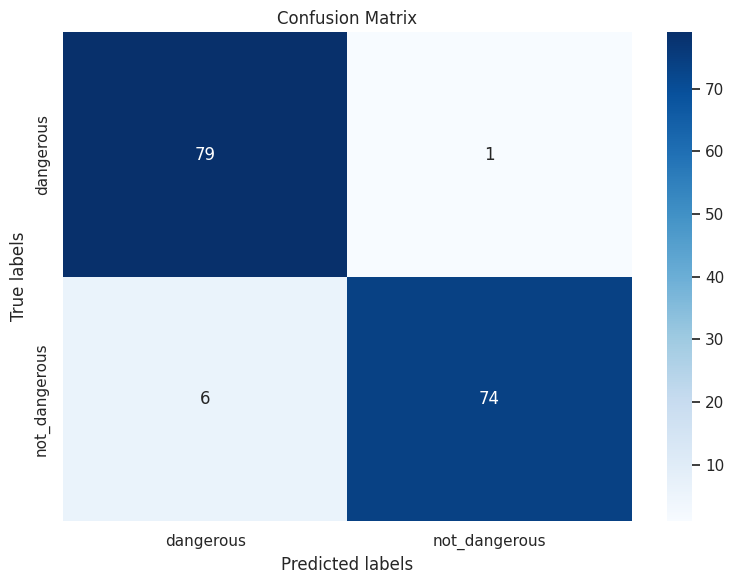

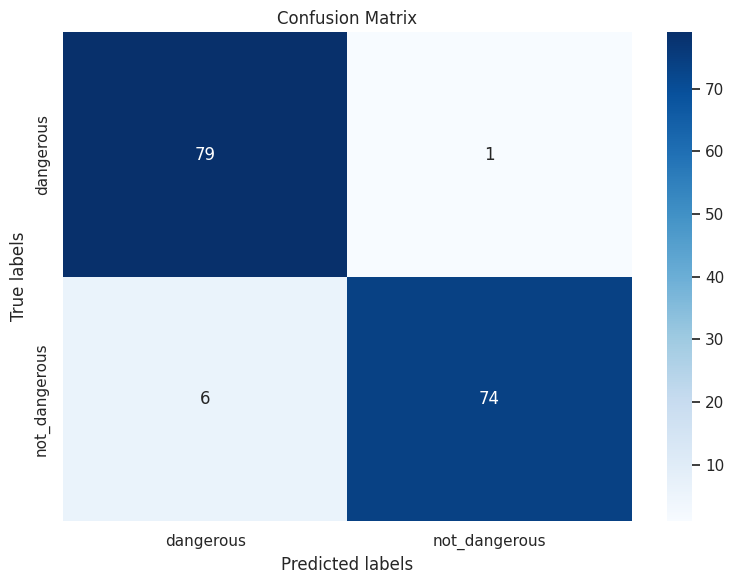

In [ ]:
def plot_confusion_matrix_with_target_names(true_labels, predicted_labels, target_names):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a figure for the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the confusion matrix with target names
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    # Adjust layout for better fit
    plt.tight_layout()

    return fig

# Sample target names for demonstration
target_names = ['dangerous', 'not_dangerous']

# Generate the plot for the confusion matrix with target names
plot_confusion_matrix_with_target_names(true_labels, predicted_dangerous, target_names)

